In [1]:
from glamor.envs.grid_world.custom_grid_world import CustomGridWorld, UniformGridWorldGoalDist
from glamor.models.encoder_lstm_model import EncoderLSTMModel
from glamor.models.basic.mlp import MLP
import torch.nn as nn

from glamor.algos.batch_train_glamor import BatchTrainGLAMOR

from glamor.utils.logging import disable_wandb

disable_wandb('runs/')

import torch
import wandb
import numpy as np

%matplotlib inline

import matplotlib.pyplot as plt

from glamor.train.scripts import train_glamor

ModuleNotFoundError: No module named 'rlpyt'

## Define environment and task distribution

In [3]:
env_cls = lambda: CustomGridWorld(start_x=3, start_y=3, grid_file='empty_small.txt')
env = env_cls()
obs = env.reset()
obs_shape = obs.shape
n_actions = env.action_space.n
state_size = 512
k = 10

device = 'cpu'

task_dist = UniformGridWorldGoalDist(env.grid)
task_iter = iter(task_dist)

### Environment visualization

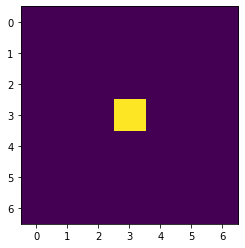

In [4]:
def get_render(grid):
    frame = np.zeros_like(grid[0])
    frame += (grid[0] // 2)
    frame += grid[1]
    return frame

def render_grid(grid):
    frame = get_render(grid)
    plt.imshow(frame)
    
render_grid(env._get_grid())

## Define model architecture

Here we just use a simple MLP to encode observations/goals and an LSTM to model the action distributions.

In [5]:
class GridEncoder(nn.Module):
    
    def __init__(self, obs_shape):
        super().__init__()
        
        obs_dim = np.prod(obs_shape)
        
        self.encoder = MLP(in_dim=obs_dim,
                           out_dim=state_size,
                           hidden=[128, 128, 128],
                           use_layer_norm=True,
                           nonlinearity=nn.ReLU)

    def forward(self, x):
        x = x / 255.
        x = x.view(x.shape[0], -1)
        return self.encoder(x)
    
shared_encoder = GridEncoder(obs_shape)
model = EncoderLSTMModel(obs_shape=obs_shape,
                         n_actions=n_actions,  
                         device=device,
                         obs_encoder=shared_encoder,
                         task_encoder=shared_encoder,
                         obs_rep_size=state_size,
                         task_rep_size=state_size,
                         state_size=state_size,
                         lstm_hidden_dim=64,
                         lstm_layers=1,
                         lstm_dropout_p=0)

Obs rep size: 512, Task rep size: 512, State size: 512


## Train GLAMOR

This should take shorter than 5 minutes on a CPU.

In [6]:
train_glamor(env_cls=env_cls,
             model=model,
             policy='open_loop',
             final_eps=0.1,
             eps_steps=int(7e4),
             n_interactions=int(7e4),
             k=k,
             lr=5e-4,
             policy_trials=50,
             clip_p_actions=-3.15,
             test_policies=['closed_loop'],
             test_tasks=['train'],
             eval_types=['labels'],
             include_labels=None,
             n_label_tasks=5,
             n_video_tasks=5,
             n_eval_tasks=5,
             device=device,
             gamma=0.5,
             n_tasks=0,
             train_tasks=task_dist,
             replay_ratio=4,
             log_period=int(1e4),
             snapshot_period=int(1e5),
             buffer_size=int(1e5),
             min_step_learn=int(3e4),
             frame_buffer=False)

  0%|          | 0/10000 [00:00<?, ?it/s]

Initialized environment.
Generated task distributions.
{'x': 0, 'y': 0}
{'x': 6, 'y': 6}
{'x': 0.6000000000000001, 'y': 0.6000000000000001}
Doing 1 batches to 5 trajs.
Effective replay ratio: 4.0
Replay buffer with obs_buffer shape (100000, 2, 7, 7)
Datatypes: obs: uint8, actions: int32
Started training.
Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff


  0%|          | 50/10000 [00:00<00:50, 197.63it/s]

Logs:
	cum_steps: 0
	replay_size: 0
	agent_eps: 1
	eval_time: 0.13513422012329102
closed_loop_grid_world_goals_label_diff:
	x: 2.8
	y: 1.6
	avg_diff: 2.2
	avg_pos_diff: 0.0
	achieved_x: 0.0
	achieved_y: 0.0
	total_achieved: 0.0


10050it [00:24, 406.89it/s]                           
  0%|          | 0/10000 [00:00<?, ?it/s]

Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff
Logs:
	step_per_sec: 404.85438311087694
	cum_steps: 10050
	replay_size: 10050
	agent_eps: 0.8714285714285714
	eval_time: 0.1173858642578125
closed_loop_grid_world_goals_label_diff:
	x: 1.6
	y: 0.2
	avg_diff: 0.9
	avg_pos_diff: 0.0
	achieved_x: 0.2
	achieved_y: 0.8
	total_achieved: 0.2


10050it [00:24, 407.91it/s]                           
  0%|          | 0/10000 [00:00<?, ?it/s]

Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff
Logs:
	step_per_sec: 403.92635340310494
	cum_steps: 20100
	replay_size: 20100
	agent_eps: 0.7422142857142857
	eval_time: 0.1575918197631836
closed_loop_grid_world_goals_label_diff:
	x: 2.2
	y: 0.8
	avg_diff: 1.5
	avg_pos_diff: 0.0
	achieved_x: 0.0
	achieved_y: 0.4
	total_achieved: 0.0


10050it [00:25, 396.80it/s]                           
  0%|          | 0/10000 [00:00<?, ?it/s]

Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff
train:
	actions_ce_loss: 1.6769534349441528
	baseline_actions_loss: 1.7012009620666504
	ce_loss: 3.3781542778015137
	main_loss: 3.3781542778015137
Logs:
	step_per_sec: 392.35641086171876
	cum_steps: 30150
	replay_size: 30150
	agent_eps: 0.6130000000000001
	eval_time: 0.1492750644683838
closed_loop_grid_world_goals_label_diff:
	x: 1.2
	y: 1.6
	avg_diff: 1.4
	avg_pos_diff: 0.0
	achieved_x: 0.4
	achieved_y: 0.2
	total_achieved: 0.2


10050it [01:11, 140.38it/s]                           


Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff


  0%|          | 50/10000 [00:00<00:28, 348.53it/s]

train:
	actions_ce_loss: 1.2314993143081665
	baseline_actions_loss: 1.552107334136963
	ce_loss: 2.78360652923584
	main_loss: 2.78360652923584
Logs:
	step_per_sec: 139.38698835419052
	cum_steps: 40200
	replay_size: 40200
	agent_eps: 0.48378571428571426
	eval_time: 0.23602890968322754
closed_loop_grid_world_goals_label_diff:
	x: 0.2
	y: 0.6
	avg_diff: 0.4
	avg_pos_diff: 0.0
	achieved_x: 0.8
	achieved_y: 0.4
	total_achieved: 0.2


10050it [01:08, 147.41it/s]                           


Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff


  0%|          | 50/10000 [00:00<00:26, 381.96it/s]

train:
	actions_ce_loss: 1.0115952491760254
	baseline_actions_loss: 1.5314394235610962
	ce_loss: 2.543034553527832
	main_loss: 2.543034553527832
Logs:
	step_per_sec: 146.16610552975055
	cum_steps: 50250
	replay_size: 50250
	agent_eps: 0.35457142857142854
	eval_time: 0.29305601119995117
closed_loop_grid_world_goals_label_diff:
	x: 0.2
	y: 0.0
	avg_diff: 0.1
	avg_pos_diff: 0.0
	achieved_x: 0.8
	achieved_y: 1.0
	total_achieved: 0.8


10050it [01:09, 144.28it/s]                           


Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff


  0%|          | 50/10000 [00:00<00:28, 354.16it/s]

train:
	actions_ce_loss: 0.9504319429397583
	baseline_actions_loss: 1.5297832489013672
	ce_loss: 2.480215072631836
	main_loss: 2.480215072631836
Logs:
	step_per_sec: 142.96026223515068
	cum_steps: 60300
	replay_size: 60300
	agent_eps: 0.2253571428571428
	eval_time: 0.4133620262145996
closed_loop_grid_world_goals_label_diff:
	x: 0.0
	y: 0.0
	avg_diff: 0.0
	avg_pos_diff: 0.0
	achieved_x: 1.0
	achieved_y: 1.0
	total_achieved: 1.0


 97%|█████████▋| 9700/10000 [01:07<00:02, 148.84it/s]

Beginning logging...
Evaluating closed_loop_grid_world_goals_label_diff
train:
	actions_ce_loss: 0.9792702794075012
	baseline_actions_loss: 1.5255439281463623
	ce_loss: 2.5048141479492188
	main_loss: 2.5048141479492188
Logs:
	step_per_sec: 147.30280853153678
	cum_steps: 70000
	replay_size: 70000
	agent_eps: 0.1006428571428571
	eval_time: 0.3443770408630371
closed_loop_grid_world_goals_label_diff:
	x: 0.0
	y: 0.0
	avg_diff: 0.0
	avg_pos_diff: 0.0
	achieved_x: 1.0
	achieved_y: 1.0
	total_achieved: 1.0


## Evaluate the model

Here we instantiate a planner, a policy, and a sampler that returns trajectories following this policy.

In [9]:
# Eval
from glamor.policies.closed_loop import ClosedLoopPolicy
from glamor.policies.open_loop import OpenLoopPolicy
from glamor.planner.sampling import SamplingPlanner
from glamor.samplers.trajectory_sampler import TrajectorySampler

planner = SamplingPlanner(model=model, 
                          gamma=0.5,
                          n_actions=n_actions, 
                          device=device,
                          num_trials=10,
                          clip_p_actions=None)
closed_loop_policy = ClosedLoopPolicy(planner=planner,
                                      horizon=k + 1,
                                      device=device,
                                      action_space=env.action_space)
open_loop_policy = OpenLoopPolicy(planner=planner,
                                    action_space=env.action_space,
                                    terminate=True,
                                    horizon=k + 1,
                                    device=device)
sampler = TrajectorySampler(env_cls=env_cls,
                            policy=closed_loop_policy,
                            horizon=k,
                            tasks=task_dist,
                            lazy_labels=True)

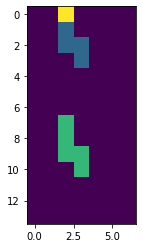

In [14]:
# Run this multiple times to see different trajectories.

trajs = sampler.collect_trajectories(n_interactions=None, 
                                     n_trajs=1)
i = 0
frames = [get_render(x) for x in trajs[i].obs]
max_frame = np.stack(frames, axis=0).max(axis=0)
task_frame = get_render(trajs[i].task.obs)
combined_frame = max_frame / 2 + task_frame
frame = np.concatenate([combined_frame, max_frame], axis=0)
plt.imshow(frame);